In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
#format_plots()
#format_pizza_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "age_vs_behavioral_age", tight_layout=False)

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
def remove_crl_female(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [7]:
# choose a model for decoder
clf = KNeighborsRegressor(n_neighbors=5)

# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=1000

In [8]:
# arrange data
# pseudo data females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_clean_pseudotime_v02.parquet')
f_psd = pd.read_parquet(path)
f_psd=f_psd.reset_index()
f_psd=f_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the female dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_clean_v2.parquet')
df_females = pd.read_parquet(path)
df_females = remove_crl_female(df_females)
f_psd = df_females.merge(f_psd, on='uuid', how='left')

#do some cleaning up
f_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
f_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
f_psd = f_psd.filter(regex=r'\d')

## convert male pseudotime to bins and remap the bins
f_psd['bins'] = pd.qcut(f_psd.index.get_level_values('psd'), len(f_psd.index.get_level_values('age').unique()),labels=False)

ages = f_psd.index.get_level_values('age').unique().to_numpy()
mapdr_females = dict(zip(list(range(len(ages))), ages))
y_temp = f_psd['bins'].to_numpy()
y_temp = [mapdr_females[item] for item in y_temp]

f_psd['remapped_bins'] = y_temp
f_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [9]:
data=f_psd.copy()

In [10]:
X=data.to_numpy()
y_age =data.index.get_level_values('remapped_bins').to_numpy()

In [11]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
mse_age = mean_squared_error(y_age, y_pred)
print(r2_age)

0.9315560148772861


In [12]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.72it/s]


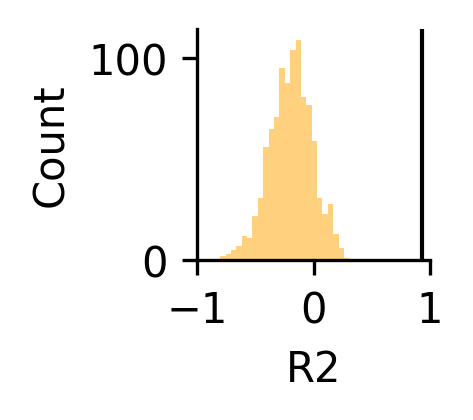

In [13]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='orange', alpha=0.5)
ax.axvline(r2_age, color='black', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'age_regression_performance_female.pdf')

In [14]:
## pseudo time decoder accuracy

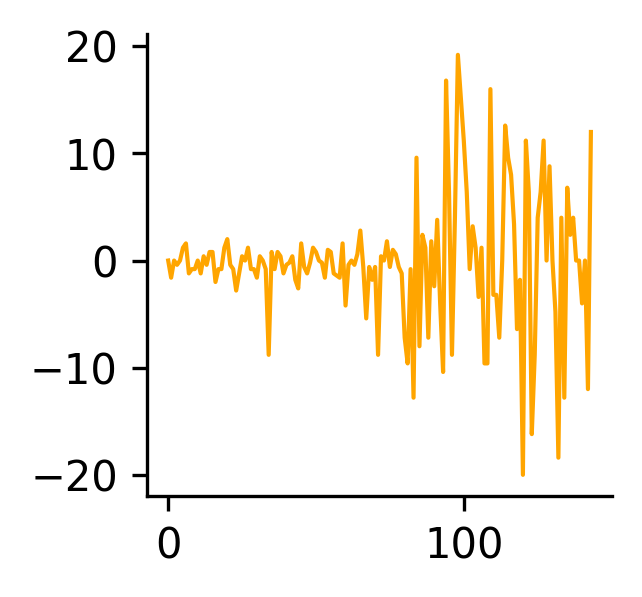

In [15]:
# plot residuals

#X=np.log(X + 1e-6) # convert to linear
res_age = y_age-y_pred
fig = plt.figure(figsize=(2, 2))
fig.dpi = 300
plt.plot (res_age, color='orange', lw=1, alpha=1)
#plt.ylim([-20, 5])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'age_regression_residules.pdf')